[INFO] 使用设备: mps
[INFO] 加载并预处理图像...


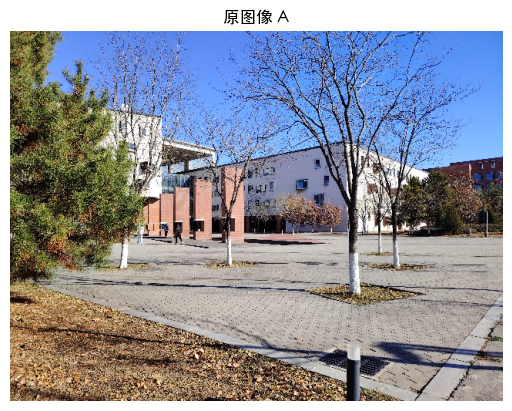

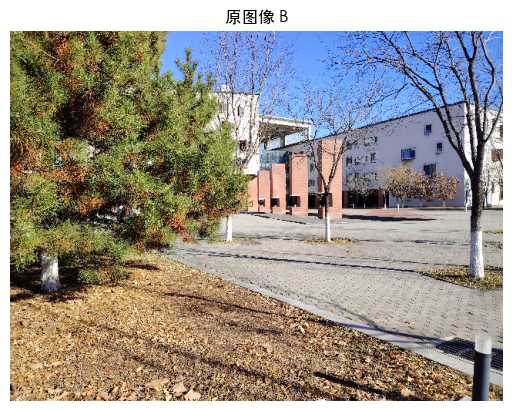

[INFO] 处理 图像 A 的特征点检测与描述符提取...
[INFO] 图像 A 检测到 2458 个关键点。
[INFO] 图像 A 有效关键点数量：2282


提取 图像 A 特征: 100%|██████████| 36/36 [00:10<00:00,  3.49it/s]


[INFO] 图像 A 描述符提取完成，形状：(2282, 512)
[INFO] 处理 图像 B 的特征点检测与描述符提取...
[INFO] 图像 B 检测到 2772 个关键点。
[INFO] 图像 B 有效关键点数量：2528


提取 图像 B 特征: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


[INFO] 图像 B 描述符提取完成，形状：(2528, 512)
[INFO] 特征提取帧率: 0.09 FPS
[INFO] 显示 图像 A 的特征点 ...


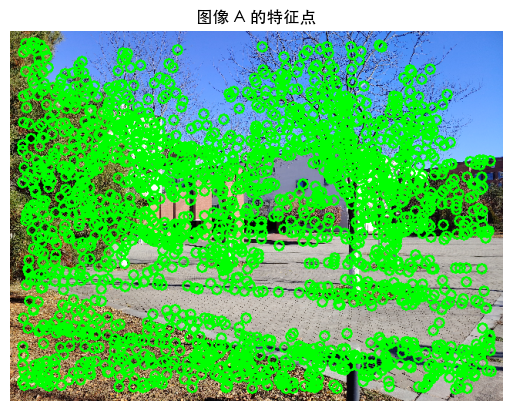

[INFO] 显示 图像 B 的特征点 ...


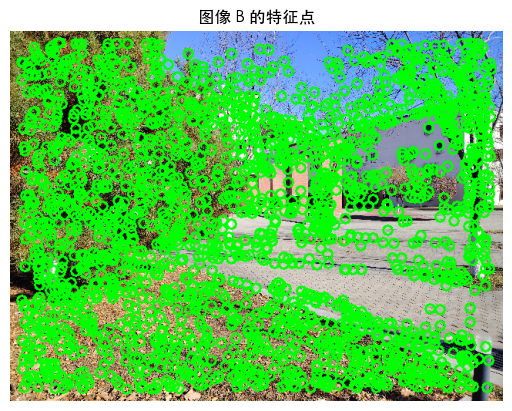

[INFO] 开始匹配特征点...
[INFO] 匹配完成，找到 354 对好匹配点。
[INFO] 绘制匹配结果...


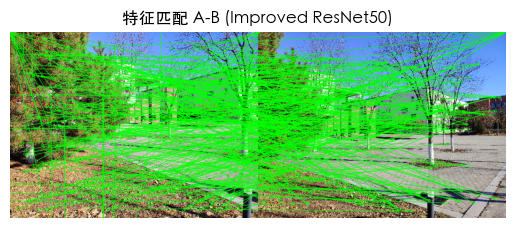

[INFO] 计算单应性矩阵并进行图像拼接...
[INFO] 内点数量：118，外点数量：236.0
[INFO] 图像拼接完成。


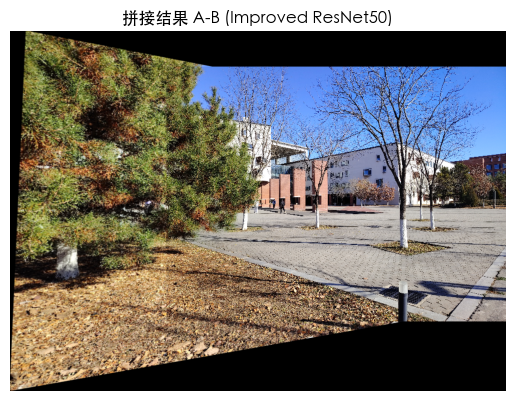

In [ ]:
import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================
# 1. 配置参数 (全部放在最前面)
# ============================

# 图像路径
imageA_path = "../../datasets/new_data/3.jpg"  
imageB_path = "../../datasets/new_data/4.jpg"

# 图像预处理参数
resize_width = 640
resize_height = 480

# SIFT 相关参数
max_keypoints = 3000         # 每张图像最多使用的关键点数

# 神经网络特征描述符提取参数
patch_size = 32             # 提取特征描述符时，每个关键点周围的图像块大小
batch_size = 64             # 批处理大小

# 拼接与匹配参数
distance_ratio = 0.9        # Lowe 的比率测试中的距离阈值 (m.distance < ratio*n.distance)
ransac_threshold = 5.0      # RANSAC 阈值
min_matches_required = 4    # 计算单应性矩阵最少匹配数量

# 保存或显示结果的可选参数（根据实际需求启用/禁用）
save_output = False
output_dir = './output_Improved_ResNet50'

# ============================
# 2. 定义工具函数
# ============================

def calculate_fps(start_time, end_time, total_images_processed=2):
    """
    计算处理速度（FPS）。
    """
    elapsed_time = end_time - start_time
    fps = total_images_processed / elapsed_time
    return fps

def show_image(image, title="Image"):
    """
    显示图像的辅助函数，支持彩色和灰度图的可视化。
    """
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def load_and_resize_image(path, width, height):
    """
    加载并缩放图像至指定大小。
    """
    image = cv2.imread(path)
    if image is None:
        raise IOError(f"无法加载图像：{path}")
    return cv2.resize(image, (width, height))

# ============================
# 3. 定义神经网络 (SEBlock + 改进的ResNet50)
# ============================

class SELayer(nn.Module):
    """
    通道注意力模块（SE Block）。
    """
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ImprovedResNet50(nn.Module):
    """
    改进的 ResNet-50：在 layer1、layer2、layer3 中嵌入 SE Block，并做多尺度特征融合。
    """
    def __init__(self):
        super(ImprovedResNet50, self).__init__()
        # 加载预训练的 ResNet-50
        self.resnet = models.resnet50(pretrained=True)

        # 前处理层
        self.layer0 = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool
        )

        # 不同深度的卷积层
        self.layer1 = self.resnet.layer1  # 输出通道 256
        self.layer2 = self.resnet.layer2  # 输出通道 512
        self.layer3 = self.resnet.layer3  # 输出通道 1024

        # 在每个层后加入 SE 注意力机制
        self.se1 = SELayer(256)
        self.se2 = SELayer(512)
        self.se3 = SELayer(1024)

        # 1x1 卷积特征融合
        self.conv_fusion = nn.Conv2d(256 + 512 + 1024, 512, kernel_size=1)
        self.descriptor_dim = 512

        # 冻结所有参数（如需微调可取消）
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # 多层特征提取
        x0 = self.layer0(x)
        x1 = self.layer1(x0);  x1 = self.se1(x1)
        x2 = self.layer2(x1);  x2 = self.se2(x2)
        x3 = self.layer3(x2);  x3 = self.se3(x3)

        # 上采样对齐到相同尺寸
        x1_up = nn.functional.interpolate(x1, size=x3.size()[2:], mode='bilinear', align_corners=False)
        x2_up = nn.functional.interpolate(x2, size=x3.size()[2:], mode='bilinear', align_corners=False)

        # 拼接融合
        x_fused = torch.cat([x1_up, x2_up, x3], dim=1)
        x_fused = self.conv_fusion(x_fused)

        # 全局平均池化，得到 512 维的描述符
        descriptor = nn.functional.adaptive_avg_pool2d(x_fused, (1, 1)).view(x.size(0), -1)
        return descriptor


# ============================
# 4. 核心处理函数
# ============================

def detectAndDescribe(image, image_name, model, device, sift, transform):
    """
    使用 SIFT 检测关键点，并用深度网络提取特征描述符。
    """
    print(f"[INFO] 处理 {image_name} 的特征点检测与描述符提取...")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1) 检测关键点
    keypoints = sift.detect(gray, None)
    keypoints = sorted(keypoints, key=lambda x: -x.response)[:max_keypoints]
    print(f"[INFO] {image_name} 检测到 {len(keypoints)} 个关键点。")

    # 2) 取出有效图像块（patch），避免越界
    valid_keypoints = []
    patches = []
    for kp in keypoints:
        x, y = int(round(kp.pt[0])), int(round(kp.pt[1]))
        x1, y1 = x - patch_size // 2, y - patch_size // 2
        x2, y2 = x1 + patch_size, y1 + patch_size
        if (x1 >= 0 and y1 >= 0 and x2 <= image.shape[1] and y2 <= image.shape[0]):
            patch = image[y1:y2, x1:x2]
            patches.append(patch)
            valid_keypoints.append(kp)

    print(f"[INFO] {image_name} 有效关键点数量：{len(valid_keypoints)}")

    # 3) 批量提取描述符
    descriptors = []
    for i in tqdm(range(0, len(patches), batch_size), desc=f"提取 {image_name} 特征"):
        batch_patches = patches[i:i+batch_size]
        batch_tensors = []
        for patch in batch_patches:
            # 缩放到 224x224，转为张量，归一化
            patch_resized = cv2.resize(patch, (224, 224))
            tensor = transform(patch_resized)
            batch_tensors.append(tensor)
        if len(batch_tensors) == 0:
            continue
        batch_tensors = torch.stack(batch_tensors).to(device)

        with torch.no_grad():
            batch_descriptors = model(batch_tensors)
            descriptors.extend(batch_descriptors.cpu().numpy())

    descriptors = np.array(descriptors, dtype=np.float32)
    print(f"[INFO] {image_name} 描述符提取完成，形状：{descriptors.shape}")
    return valid_keypoints, descriptors

def match_keypoints(desA, desB):
    """
    使用 BFMatcher + Lowe Ratio Test 匹配描述符。
    """
    print("[INFO] 开始匹配特征点...")
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    raw_matches = matcher.knnMatch(desA, desB, k=2)

    good_matches = []
    matches = []
    for m, n in raw_matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))

    print(f"[INFO] 匹配完成，找到 {len(good_matches)} 对好匹配点。")
    return good_matches, matches

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    绘制匹配可视化。
    """
    print("[INFO] 绘制匹配结果...")
    draw_params = dict(
        matchColor=(0, 255, 0),
        singlePointColor=(255, 0, 0),
        matchesMask=None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    vis = cv2.drawMatchesKnn(
        imageB, kpsB,
        imageA, kpsA,
        good_matches,
        None,
        **draw_params
    )
    return vis

def stitch_images(center_image, align_image, center_kps, align_kps, matches):
    """
    根据匹配对计算单应性矩阵并进行图像拼接。
    """
    print("[INFO] 计算单应性矩阵并进行图像拼接...")
    if len(matches) < min_matches_required:
        print(f"[WARN] 匹配点不足（{len(matches)} < {min_matches_required}），拼接无法完成。")
        return None

    pts_center = np.float32([center_kps[i].pt for (i, _) in matches])
    pts_align  = np.float32([align_kps[i].pt  for (_, i) in matches])
    H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

    inliers = np.sum(status)
    print(f"[INFO] 内点数量：{inliers}，外点数量：{len(status) - inliers}")

    # 拼接
    height_center, width_center = center_image.shape[:2]
    height_align,  width_align  = align_image.shape[:2]

    corners_center = np.float32([[0, 0],
                                 [0, height_center],
                                 [width_center, height_center],
                                 [width_center, 0]]).reshape(-1, 1, 2)
    corners_align  = np.float32([[0, 0],
                                 [0, height_align],
                                 [width_align, height_align],
                                 [width_align, 0]]).reshape(-1, 1, 2)

    corners_align_transformed = cv2.perspectiveTransform(corners_align, H)
    all_corners = np.concatenate((corners_center, corners_align_transformed), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())
    translation_dist = [-x_min, -y_min]

    H_translation = np.array([
        [1, 0, translation_dist[0]],
        [0, 1, translation_dist[1]],
        [0, 0, 1]
    ], dtype=np.float32)

    result = cv2.warpPerspective(align_image, H_translation @ H, (x_max - x_min, y_max - y_min))
    result[translation_dist[1]:translation_dist[1]+height_center,
           translation_dist[0]:translation_dist[0]+width_center] = center_image
    print("[INFO] 图像拼接完成。")
    return result

def show_keypoints(image, keypoints, title="Keypoints"):
    """
    显示特征点，使用较大圆圈标识位置。
    """
    print(f"[INFO] 显示 {title} ...")
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 6, (0, 255, 0), 2)
    show_image(image_with_keypoints, title)

# ============================
# 5. 主流程
# ============================

if __name__ == "__main__":
    plt.rcParams['font.sans-serif'] = ['STHeiti']  # 显示中文
    plt.rcParams['axes.unicode_minus'] = False

    # 检查设备：Apple Silicon 上可使用 MPS
    device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
    print(f"[INFO] 使用设备: {device}")

    # 加载并缩放图像
    print("[INFO] 加载并预处理图像...")
    imageA = load_and_resize_image(imageA_path, resize_width, resize_height)
    imageB = load_and_resize_image(imageB_path, resize_width, resize_height)
    show_image(imageA, "原图像 A")
    show_image(imageB, "原图像 B")

    # 初始化模型、转换、SIFT
    model = ImprovedResNet50().to(device)
    model.eval()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    sift = cv2.SIFT_create(nfeatures=max_keypoints)

    # 处理图像A和B，提取描述符
    start_time = time.time()
    kpsA, desA = detectAndDescribe(imageA, "图像 A", model, device, sift, transform)
    kpsB, desB = detectAndDescribe(imageB, "图像 B", model, device, sift, transform)
    end_time = time.time()

    # 计算帧率
    fps = calculate_fps(start_time, end_time, total_images_processed=2)
    print(f"[INFO] 特征提取帧率: {fps:.2f} FPS")

    # 显示关键点
    show_keypoints(imageA, kpsA, "图像 A 的特征点")
    show_keypoints(imageB, kpsB, "图像 B 的特征点")

    # 匹配特征
    good_matches_AB, matches_AB = match_keypoints(desA, desB)
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    if vis_AB is not None:
        show_image(vis_AB, "特征匹配 A-B (Improved ResNet50)")

    # 拼接图像
    stitchedAB = stitch_images(imageA, imageB, kpsA, kpsB, matches_AB)
    if stitchedAB is not None:
        show_image(stitchedAB, "拼接结果 A-B (Improved ResNet50)")
        if save_output:
            os.makedirs(output_dir, exist_ok=True)
            output_filename = os.path.join(output_dir, "stitched_AB.jpg")
            cv2.imwrite(output_filename, stitchedAB)
            print(f"[INFO] 拼接结果已保存至: {output_filename}")
    else:
        print("[WARN] 拼接失败，匹配点不足。")